# Linear regression with ``gluon``

## 导入库函数

In [1]:
import mxnet as mx
from mxnet import nd
from mxnet import autograd
from mxnet import gluon
mx.random.seed(1)

## 定义context

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## 创建数据

$$y = 1.2 \cdot X[0]-3.4 \cdot X[1]+4.2$$

In [3]:
num_inputs = 2
num_outputs = 1
num_example = 1000

true_w = [1.2, -3.4]
true_b = 4.2

def real_fn(X):
    return true_w[0] * X[:,0] + true_w[1] * X[:, 1] + true_b

X = nd.random.normal(shape=(num_example, num_inputs))
noise = .01 * nd.random.normal(shape=num_example)
y = real_fn(X) + noise

## 使用``gluon``读取数据

In [4]:
batch_size = 12
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y), batch_size=batch_size, shuffle=True)

In [5]:
for data, label in train_data:
    print(data, label)
    break  


[[ 0.25398585  1.60730255]
 [-2.26174664 -0.5717749 ]
 [ 0.69706553 -0.18887992]
 [-0.44612366 -0.15578145]
 [-0.8762328  -1.09077787]
 [ 0.22852479  1.36539459]
 [ 0.82342088  0.38115725]
 [ 1.12978852 -2.17294288]
 [-1.03682768 -1.03667784]
 [ 0.95402157 -1.19392276]
 [-0.76422656 -0.38377118]
 [ 0.00360237  0.1376956 ]]
<NDArray 12x2 @cpu(0)> 
[ -0.96352875   3.43353677   5.69912624   4.21623564   6.88841724
  -0.16178308   3.90932107  12.93677235   6.47913122   9.39478207
   4.59309149   3.72664905]
<NDArray 12 @cpu(0)>


## 使用``gluon``定义模型

In [6]:
# method 1
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))

# method 2
net = gluon.nn.Dense(1, in_units=2)

In [7]:
net.weight

Parameter dense1_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)

In [8]:
net.bias

Parameter dense1_bias (shape=(1,), dtype=<class 'numpy.float32'>)

In [9]:
net.weight.data

<bound method Parameter.data of Parameter dense1_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)>

In [10]:
net.bias.data

<bound method Parameter.data of Parameter dense1_bias (shape=(1,), dtype=<class 'numpy.float32'>)>

In [11]:
net.collect_params()

dense1_ (
  Parameter dense1_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
  Parameter dense1_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)

## 初始化参数

我们通过一个`ParameterDict`的`.initialize()`方法来来初始化参数，该方法需要两个参数。

* 一个initializer, 我们可以在 `mx.init` 模块中找到这些initializer. 
* 这些参数所处的context. (In this case we'll pass in the `model_ctx`. Most often this will either be a GPU or a list of GPUs). 

*MXNet* provides a variety of common initializers in ``mxnet.init``.
To keep things consistent with the model we built by hand, 
we'll initialize each parameter by sampling from a standard normal distribution, 
using `mx.init.Normal(sigma=1.)`.

In [12]:
net.collect_params().initialize(mx.init.Normal(sigma=1)) #由于当前所处单CPU环境，所以先不指定ctx参数

## ``gluon``的延迟初始化机制

当我们调用``initialize``方法时，``gluon``会将每个参数与一个initializer关联起来。但是，**真正的初始化**被延迟加载了，直到我们进行第一次前向传播，换句话说，参数只有当真正需要的时候才会被初始化。当我们第一次调用`net.weight.data()`方法时，会报错：

``DeferredInitializationError: Parameter dense2_weight has not been initialized yet because initialization was deferred. Actual initialization happens during the first forward pass. Please pass one batch of data through the network before accessing Parameters.``

下面我们通过net来传递一个数据以此来检验输出结果

In [13]:
example_data = nd.array([[4,7]])
net(example_data)


[[ 11.85281181]]
<NDArray 1x1 @cpu(0)>

In [14]:
print(net.weight.data())
print(net.bias.data())


[[-1.22338355  2.39233518]]
<NDArray 1x2 @cpu(0)>

[ 0.]
<NDArray 1 @cpu(0)>


## 维度推测

``gluon`` 可以对参数的shape进行自动推断，因为只有当数据在网络中进行前向传播的时候参数才会被初始化，因此我们不需要指定输入维度而只需要指定输出维度

In [15]:
net = gluon.nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=1.))

## 使用``gluon``定义损失函数

In [16]:
square_loss = gluon.loss.L2Loss()

## 使用``gluon``定义优化器

In [17]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

## 训练

In [18]:
epochs = 10
loss_sequence = []
num_batches = num_example / batch_size

# 加权移动平均损失
niter = 0
moving_loss = 0
smoothing_constant = 0.01
moving_loss_sequence = []

for epoch in range(epochs):
    cumulative_loss = .0
    for i, (data, label) in enumerate(train_data): 
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
        
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        est_loss = moving_loss / 1 - (1-smoothing_constant)**niter
        moving_loss_sequence.append(est_loss)
        if (niter+1)%100 == 0:
             print("Epoch %s, Batch %s, Moving Average loss: %s, Avg loss: %s" % (epoch, niter, est_loss, cumulative_loss / num_example))
    loss_sequence.append(cumulative_loss)

Epoch 1, Batch 99, Moving Average loss: 2.12905538156, Avg loss: 0.361015842438
Epoch 2, Batch 199, Moving Average loss: 1.15001388821, Avg loss: 0.120715826631
Epoch 3, Batch 299, Moving Average loss: 0.482010092074, Avg loss: 0.0334746645391
Epoch 4, Batch 399, Moving Average loss: 0.186864060902, Avg loss: 0.00900802575052
Epoch 5, Batch 499, Moving Average loss: 0.0700443648045, Avg loss: 0.00223718950478
Epoch 7, Batch 599, Moving Average loss: 0.0259300433221, Avg loss: 3.3645826974e-05
Epoch 8, Batch 699, Moving Average loss: 0.00956387317755, Avg loss: 2.57771276956e-05
Epoch 9, Batch 799, Moving Average loss: 0.00353875117967, Avg loss: 2.72247371904e-05


In [19]:
net.weight.data()


[[ 1.20170069 -3.39869833]]
<NDArray 1x2 @cpu(0)>

In [20]:
net.bias.data()


[ 4.19861317]
<NDArray 1 @cpu(0)>

Text(0,0.5,'average loss')

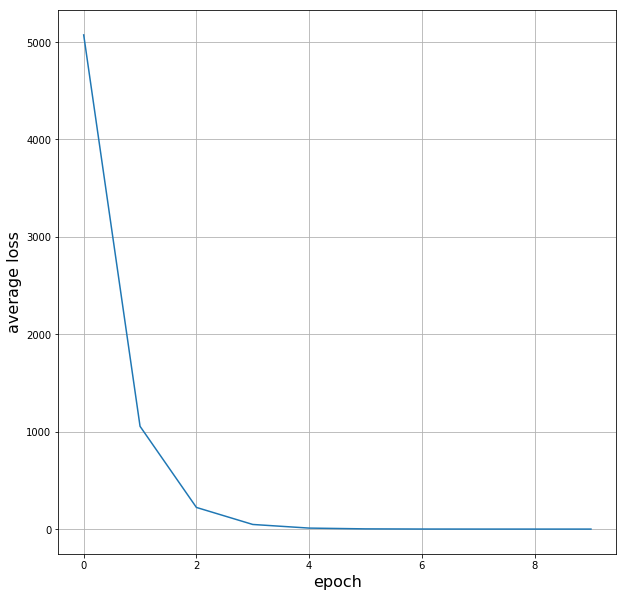

In [22]:
# plot the averaging loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(list(range(len(loss_sequence))), loss_sequence)
plt.grid(True, which="both")
plt.xlabel("epoch", fontsize="16")
plt.ylabel("average loss", fontsize="16")

## ``gluon``查看参数的方法

In [29]:
# 获取参数的方法
params = net.collect_params()
for param in params.values():
    print(param.name, param.data())

dense2_weight 
[[ 1.20170069 -3.39869833]]
<NDArray 1x2 @cpu(0)>
dense2_bias 
[ 4.19861317]
<NDArray 1 @cpu(0)>
